### 0. Pip Install & Load Relevant Libaries

In [ ]:
# To mount Google Drive
from google.colab import drive

# Warnings

import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

# To quickly access files
import os
import glob

# Pandas
import pandas as pd

# Polyglot
try:
    from polyglot.detect import Detector
    import icu
except:
    !pip install polyglot
    !pip install PyICU
    !pip install pycld2
    from polyglot.detect import Detector
    import icu

# html
import html

# Normalized from longform UTF-8 to ASCII encoding. This will remove accents in characters and ensure that words like "naïve" will simply be interpreted as (and therefore not differentiated from) "naive".
from unicodedata import normalize

# import nltk resources
import nltk

resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger","wordnet"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)
        
from nltk.corpus import stopwords, wordnet

# string library
import string

# regex
import re

# wordcloud
from wordcloud import WordCloud
from collections import Counter

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# ast
import ast

# json
import json

# yaml
import yaml

# time 
import time

# numpy
import numpy as np

# math

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Mount Drive

In [ ]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Functions

In [ ]:
def reformat_reviews_df(df,product_id,scraping_checklist_df):
    # Drop rows which are actually headers 
    df = df[df.ASIN != 'ASIN']

    # Fill in missing ASIN
    df['ASIN'] = df['ASIN'].fillna(value=product_id)

    # Reformat profile link for profile crawling
    df['new_profile_link'] = "https://www.amazon.com" + df['profile_link'].astype(str)

    # Check if stars column is correctly named:
    if 'ï»¿stars' in df.columns.values.tolist() and 'stars' not in df.columns.values.tolist():
        df = df.rename(columns={'ï»¿stars':'stars'})
    
    # Assign Product Name
    df = pd.merge(df,scraping_checklist_df,left_on=['ASIN'], right_on = ['Product ASIN'], how = 'left')

    # Lowercase title text
    df['clean_title'] = df['title'].str.lower()

    # Decode & lowercase comment text
    df['decoded_comment'] = df.comment.astype(str)
    df['decoded_comment'] = df.decoded_comment.apply(lambda x: html.unescape(x))
    df['decoded_comment'] = df.decoded_comment.apply(lambda text: ''.join(x for x in text if x.isprintable()))
    df["decoded_comment"] = df["decoded_comment"].apply(lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore"))
    df['decoded_comment']= df['decoded_comment'].str.lower()

    # Cleaning stars
    df['ratings'] = df.stars.astype(str)
    df['ratings'] = df.ratings.apply(lambda x: x.split())
    df['ratings'] = df.ratings.apply(lambda x: float(x[0])/float(x[3]))

    # Data wrangling & Fill in blanks for Verified Puchase
    df['clean_verified'] = df.verified.astype(str)
    df.loc[df.clean_verified == 'Verified Purchase', 'clean_verified'] = 1
    df['clean_verified'] = df['clean_verified'].fillna(value=0)

    # Extract Account Number
    df['account_number'] = df['profile_link'].astype(str)
    df['account_number'] = df['account_number'].str.split('.').str[-1]

    # Data wrangling for voting columns
    df['clean_voting'] = df['voting']
    df['clean_voting'] = df['clean_voting'].fillna(value=0)
    df['clean_voting'] = df.clean_voting.astype(str)
    df['clean_voting'] = df.clean_voting.apply(lambda x: x.split(' ')[0])
    df.loc[df.clean_voting == 'One', 'clean_voting'] = 1
    df.loc[df.clean_voting == 'Helpful', 'clean_voting'] = 0
    df['clean_voting'] = df.clean_voting.astype(str)
    df['clean_voting'] = df.clean_voting.apply(lambda x: x.replace(',', '') if ',' in x else x)
    df['clean_voting'] = df.clean_voting.astype(int)

    # Extracting location & date posted into two different columns
    df['location'] = df.date.astype(str)
    df['date_posted'] = df.date.astype(str)
    df['location'] = df.location.apply(lambda x: (' '.join(x.split(' ')[3:])).split('on')[0].strip())
    df['date_posted'] = df.date_posted.apply(lambda x: (' '.join(x.split(' ')[3:])).split('on')[1].strip())

    # Identifying opinion's language
    df['poly_obj'] = df.decoded_comment.apply(lambda x: Detector(x, quiet=True))
    df['language'] = df['poly_obj'].apply(lambda x: icu.Locale.getDisplayName(x.language.locale))
    df['language_confidence'] = df['poly_obj'].apply( lambda x: x.language.confidence)

    # Lowercase product name
    df['clean_product_name'] = df['Product name'].str.lower()
    
    # Remove unnecessary columns
    for column in ['poly_obj','Product ASIN']:
        del df[column]
    
    # return dataframe
    return df

def reformat_profile_df(df):
    # Decode & lowercase comment text
    df['decoded_comment'] = df.text.astype(str)
    df['decoded_comment'] = df.decoded_comment.apply(lambda x: html.unescape(x))
    df['decoded_comment'] = df.decoded_comment.apply(lambda text: ''.join(x for x in text if x.isprintable()))
    df["decoded_comment"] = df["decoded_comment"].apply(lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore"))
    df['decoded_comment']= df['decoded_comment'].str.lower()

    # Lowercase product name
    df['clean_product_name'] = df['product'].str.lower()

    # convert ranking string to integer
    df['ranking'] = df['ranking'].str.replace(',', '')
    df['ranking'] = df['ranking'].fillna(value=0)
    df['ranking'] = df['ranking'].astype(int)
    
    # return dataframe
    return df

def reformat_product_info_df(df):
    # Decode & lowercase comment text
    df['decoded_comment'] = df.description.fillna(value='')
    df['decoded_comment'] = df.decoded_comment.apply(lambda x: html.unescape(x))
    df['decoded_comment'] = df.decoded_comment.apply(lambda text: ''.join(x for x in text if x.isprintable()))
    df["decoded_comment"] = df["decoded_comment"].apply(lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore"))
    df['decoded_comment']= df['decoded_comment'].str.lower()

    # Cleaning stars
    df['clean_rating'] = df.rating.fillna(value='0 out of 5')
    df['clean_rating'] = df.clean_rating.apply(lambda x: x.split())
    df['clean_rating'] = df.clean_rating.apply(lambda x: float(x[0])/float(x[3]))

    # extract price
    df['clean_price'] = df.price.fillna(value='$0.00')
    df['clean_price'] = df.clean_price.apply(lambda x: re.findall( r'\$([0-9]+\.?[0-9]+)', x))
    df['clean_price'] = df.clean_price.apply(lambda x: x[0])
    df.loc[df.clean_price == 0, 'clean_price'] = np.nan
    
    # return dataframe
    return df

def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = re.sub(r'www\S+', '', text) # remove www links
    text = re.sub(r'.*\.com', '', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def remove_symbols(text):
    """ Removes all symbols and keep alphanumerics """
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in text if word not in whitelist]

def keep_alphanum(text):
    """ Keep Alphanumeric characters """
    return [word for word in text if word.isalnum()]

def remove_stopwords(text):
    """ Remove Stopwords """
    stop_list = stopwords.words('english')
    stop_list += string.punctuation
    stop_list += [] #any other stop words
    return [word for word in text if word not in stop_list]


def remove_apostrophes(text):
    """ Remove words which have 's with a space """
    return [re.sub(r"'s", "",word) for word in text]

""" Creates a dictionary with slangs and their equivalents and replaces them """
def replaceSlang(text):
    with open('/content/drive/My Drive/FYP/FYP Y4S1/preprocessing_resources/slangs.txt',encoding="ISO-8859-1") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [slang_map[word] if word in slang_map.keys() else word for word in text]

""" Creates a dictionary with contractions and their equivalents and replaces them """
def replaceContraction(text):
    with open('/content/drive/My Drive/FYP/FYP Y4S1/preprocessing_resources/contractions.txt',encoding="ISO-8859-1") as file:
        contraction_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [contraction_map[word] if word in contraction_map.keys() else word for word in text]

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def replaceElongatedText(text):
    return [replaceElongated(word) for word in text]

def remove_multispaces(text):
    """ Replace multiple spaces with only 1 space """
    return [re.sub(r' +', " ",word) for word in text]
    
def normalize_word(text):
    """ Own mapping function """
    replacement_dict = {"l'oreal": 'loreal', "l'oreals":'loreal','b/c': 'because','amazon.com':'amazon',\
                        'cake-y':'cakey', 'build-able':'buildable', 'wal-mart':'walmart', \
                        'q-tip':'cotton swab','l"oreal': 'loreal', 'l"oreals':'loreal',\
                        "a/c":"air conditioning", "co-workers":"colleague", "co-worker":"colleague",\
                        "y'all":"you all"}

    text = [replacement_dict[word] if word in replacement_dict.keys() else word for word in text]

    return text

def lemmatize_words(feedback):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(feedback)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None and word not in stopwords.words('english'):
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word))

    return (lemmatized_sentence)

def clean_text(texts):
    new_texts = [nltk.word_tokenize(str(text)) for text in texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]
    new_texts = [remove_links(text) for text in new_texts]
    new_texts = [removeEmoticons(text) for text in new_texts]
    new_texts = [nltk.word_tokenize(str(text)) for text in new_texts]
    new_texts = [replaceSlang(text) for text in new_texts]
    new_texts = [replaceContraction(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_apostrophes((text)) for text in new_texts]
    new_texts = [replaceElongatedText((text)) for text in new_texts]
    new_texts = [remove_symbols((text)) for text in new_texts]
    new_texts = [keep_alphanum(text) for text in new_texts]
    new_texts = [lemmatize_words(text) for text in new_texts]
    new_texts = [remove_stopwords(text) for text in new_texts]
    new_texts = [remove_multispaces(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]

    return new_texts

def generate_wordclouds(df,column,usecase):
    ans = []
    for text in df[column].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip():
        text = str(text)
        text = nltk.word_tokenize(text)
        if usecase == "symbols":
            for word in text:
                if re.findall('\W\S',word) != []:
                    ans.append(word)
        elif usecase == 'digits':
            for word in text:
                if re.findall(r'\d+',word) != []:
                    ans.append(word)
        elif usecase == "consective":
            for word in text:
                if re.findall(r'([a-z])\1\1+',word) != []:
                    ans.append(word)
    try:
        word_cloud_dict=Counter(ans)
        wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

        plt.figure(figsize=(15,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except:
        print("Data is cleaned")

## Reviews

### 2. Clean data while loading all reviews into a dataframe

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_products/consolidated_products_without_text_preprocessing.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_products/'
    df = pd.read_csv('consolidated_products_without_text_preprocessing.csv',encoding='utf-8')
else:
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/preprocessing_resources'
    scraping_checklist_df = pd.read_excel('Amazon scraping checklist.xlsx')
    scraping_checklist_df = scraping_checklist_df[['Product name','Product Category','Product ASIN']]

    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/products/'
    
    filename_lst = [i for i in glob.glob('*.csv')]
    df = pd.read_csv(filename_lst[0],encoding='utf-8')
    asin = filename_lst[0][8:len(filename_lst[0])-4]
    df = reformat_reviews_df(df,asin,scraping_checklist_df)

    for filename in reformat_reviews_dffilename_lst[1:]:
        current_df = pd.read_csv(filename,encoding='utf-8')
        asin = filename[8:len(filename)-4]

        current_df = reformat_reviews_df(current_df,asin,scraping_checklist_df)
        df = pd.concat([df, current_df], axis=0)

    df = df.drop_duplicates()
    
    %cd '../consolidated_products/'
    df.to_csv('consolidated_products_without_text_preprocessing.csv',index=False,encoding='utf-8')

print(len(df))
display(df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_products
89531


,stars,profile_name,profile_link,profile_image,title,date,style,verified,comment,voting,review_images,ASIN,new_profile_link,Product name,Product Category,clean_title,decoded_comment,ratings,clean_verified,account_number,clean_voting,location,date_posted,language,language_confidence,clean_product_name
0,5.0 out of 5 stars,Willow,/gp/profile/amzn1.account.AHR5T6MM2O3EPWKQS2TB...,https://images-na.ssl-images-amazon.com/images...,Love love love,"Reviewed in the United States on December 11, ...",Style Name: Rosy Tone MoisturizerSize: 1.7 Ounce,Verified Purchase,"Love, love, love this moisturizer! As a woman ...",One person found this helpful\n \n ...,0,B01M09QQI0,https://www.amazon.com/gp/profile/amzn1.accoun...,Face Moisturizer by L’Oreal Paris Skin Care I ...,Loreal Skincare,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,United States,"December 11, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
1,5.0 out of 5 stars,Julie,/gp/profile/amzn1.account.AGNSFZ5L2RRLAZVJLP44...,https://images-na.ssl-images-amazon.com/images...,Love it,"Reviewed in the United States on December 27, ...",Style Name: Fragrance FreeSize: 1.7 Ounce,Verified Purchase,This moisturizer works so well with my skin. ...,Helpful,0,B01M09QQI0,https://www.amazon.com/gp/profile/amzn1.accoun...,Face Moisturizer by L’Oreal Paris Skin Care I ...,Loreal Skincare,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,United States,"December 27, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
2,5.0 out of 5 stars,eulyssa j. jones,/gp/profile/amzn1.account.AEBGB5TXQVZDADM6NVF3...,https://images-na.ssl-images-amazon.com/images...,They say that I look younger!,"Reviewed in the United States on August 13, 2019",Style Name: Rosy Tone MoisturizerSize: 1.7 Ounce,Verified Purchase,I know. Sounds to good to be true. Maybe fol...,2 people found this helpful\n \n ...,0,B01M09QQI0,https://www.amazon.com/gp/profile/amzn1.accoun...,Face Moisturizer by L’Oreal Paris Skin Care I ...,Loreal Skincare,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,United States,"August 13, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
3,1.0 out of 5 stars,Kathy,/gp/profile/amzn1.account.AGOPMI2JKQH5F2BP2PUL...,https://images-na.ssl-images-amazon.com/images...,Old,"Reviewed in the United States on October 19, 2018",Style Name: Rosy Tone MoisturizerSize: 1.7 Ounce,Verified Purchase,The first jar I ordered smelled wonderful and ...,6 people found this helpful\n \n ...,0,B01M09QQI0,https://www.amazon.com/gp/profile/amzn1.accoun...,Face Moisturizer by L’Oreal Paris Skin Care I ...,Loreal Skincare,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,United States,"October 19, 2018",English,99.0,face moisturizer by l’oreal paris skin care i ...
4,4.0 out of 5 stars,Teresa,/gp/profile/amzn1.account.AF7YT2BIHNQZZNOQF6JG...,https://images-na.ssl-images-amazon.com/images...,does what it claims,"Reviewed in the United States on January 10, 2020",Style Name: Rosy Tone MoisturizerSize: 2.55 Ounce,Verified Purchase,I have used this product for about six weeks. ...,Helpful,0,B01M09QQI0,https://www.amazon.com/gp/profile/amzn1.accoun...,Face Moisturizer by L’Oreal Paris Skin Care I ...,Loreal Skincare,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,United States,"January 10, 2020",English,99.0,face moisturizer by l’oreal paris skin care i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89526,4.0 out of 5 stars,Haripriya,NaN,https://images-eu.ssl-images-amazon.com/images...,NaN,"Reviewed in India on July 23, 2018",Color: Everlasting Plum,Verified Purchase,Everlasting plum is my favorite shade. Very pi...,NaN,0,B0047ENUXE,https://www.a

### 3. Check for Null Values

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89531 entries, 0 to 89530
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stars                89531 non-null  object 
 1   profile_name         89530 non-null  object 
 2   profile_link         78980 non-null  object 
 3   profile_image        89531 non-null  object 
 4   title                78971 non-null  object 
 5   date                 89531 non-null  object 
 6   style                73921 non-null  object 
 7   verified             77151 non-null  object 
 8   comment              89522 non-null  object 
 9   voting               80933 non-null  object 
 10  review_images        89531 non-null  int64  
 11  ASIN                 89531 non-null  object 
 12  new_profile_link     89531 non-null  object 
 13  Product name         89531 non-null  object 
 14  Product Category     89531 non-null  object 
 15  clean_title          78966 non-null 

### 4. Get unique Profile URLs

In [ ]:
if os.path.exists('consolidated_profiles.csv'):
    unique_profiles_df = pd.read_csv('consolidated_profiles.csv',encoding='utf-8')
else:
    unique_profiles = list(df['new_profile_link'].unique())
    unique_profiles_df = pd.DataFrame(unique_profiles, columns =['urls']) 
    unique_profiles_df.to_csv('consolidated_profiles.csv',index=False,encoding='utf-8')

print(len(unique_profiles_df))
display(unique_profiles_df)

65929


,urls
0,https://www.amazon.com/gp/profile/amzn1.accoun...
1,https://www.amazon.com/gp/profile/amzn1.accoun...
2,https://www.amazon.com/gp/profile/amzn1.accoun...
3,https://www.amazon.com/gp/profile/amzn1.accoun...
4,https://www.amazon.com/gp/profile/amzn1.accoun...
...,...
65924,https://www.amazon.com/gp/profile/amzn1.accoun...
65925,https://www.amazon.com/gp/profile/amzn1.accoun...
65926,https://www.amazon.com/gp/profile/amzn1.accoun...
65927,https://www.amazon.com/gp/profile/amzn1.accoun...


### 5. Filtered neccessary columns for text cleaning

In [ ]:
text_cleaning_df = df.copy()
text_cleaning_df = text_cleaning_df[['ASIN','Product Category','clean_title','decoded_comment','ratings','clean_verified', 
                                     'account_number','clean_voting','location','date_posted','language','language_confidence','clean_product_name']]
text_cleaning_df

,ASIN,Product Category,clean_title,decoded_comment,ratings,clean_verified,account_number,clean_voting,location,date_posted,language,language_confidence,clean_product_name
0,B01M09QQI0,Loreal Skincare,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,United States,"December 11, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
1,B01M09QQI0,Loreal Skincare,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,United States,"December 27, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
2,B01M09QQI0,Loreal Skincare,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,United States,"August 13, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
3,B01M09QQI0,Loreal Skincare,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,United States,"October 19, 2018",English,99.0,face moisturizer by l’oreal paris skin care i ...
4,B01M09QQI0,Loreal Skincare,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,United States,"January 10, 2020",English,99.0,face moisturizer by l’oreal paris skin care i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89526,B0047ENUXE,Loreal Cosmetics,NaN,everlasting plum is my favorite shade. very pi...,0.8,1.0,NaN,0,NaN,"July 23, 2018",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
89527,B0047ENUXE,Loreal Cosmetics,NaN,i got this for 564 i mean this is a steal for ...,1.0,1.0,NaN,1,NaN,"October 11, 2017",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
89528,B0047ENUXE,Loreal Cosmetics,NaN,i love the color absolutely. it brightens up t...,0.8,1.0,NaN,0,NaN,"July 12, 2015",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
89529,B0047ENUXE,Loreal Cosmetics,NaN,very nice shade to give you pink lips..quality...,1.0,1.0,NaN,0,NaN,"December 11, 2018",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."


### 6. Get distribution of languages

In [ ]:
language_df = text_cleaning_df.groupby(by="language").size().reset_index(name='count')
english_count = int(language_df[language_df['language'] == 'English']['count'])
total_count = int(language_df['count'].sum())
print("Number of reviews which are English out of entire dataset: {}% ({} / {})".format(english_count/total_count*100,english_count,total_count))

Number of reviews which are English out of entire dataset: 95.07656565882209% (85123 / 89531)


In [ ]:
display(language_df[language_df['language'] != 'English'].sort_values(by=['count'],ascending=False))
print("Number of Foreign Languages: {}".format(len(language_df[language_df['language'] != 'English'])))

,language,count
56,Spanish,2559
27,Italian,496
18,German,328
16,French,257
11,Dutch,188
...,...,...
55,Somali,1
21,Hausa,1
53,Shona,1
46,Oromo,1


Number of Foreign Languages: 72


### 7. Keep English Text & Verify Results

In [ ]:
if os.path.exists('english_reviews_without_text_preprocessing.csv'):
    english_df = pd.read_csv('english_reviews_without_text_preprocessing.csv',encoding='utf-8')
else:
    english_df = text_cleaning_df[text_cleaning_df['language'] == 'English']
    english_df.to_csv('english_reviews_without_text_preprocessing.csv',index=False,encoding='utf-8')

print(len(english_df))
display(english_df)

# dummy variable to generate chart
generate_chart = False

85123


,ASIN,Product Category,clean_title,decoded_comment,ratings,clean_verified,account_number,clean_voting,location,date_posted,language,language_confidence,clean_product_name
0,B01M09QQI0,Loreal Skincare,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,United States,"December 11, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
1,B01M09QQI0,Loreal Skincare,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,United States,"December 27, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
2,B01M09QQI0,Loreal Skincare,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,United States,"August 13, 2019",English,99.0,face moisturizer by l’oreal paris skin care i ...
3,B01M09QQI0,Loreal Skincare,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,United States,"October 19, 2018",English,99.0,face moisturizer by l’oreal paris skin care i ...
4,B01M09QQI0,Loreal Skincare,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,United States,"January 10, 2020",English,99.0,face moisturizer by l’oreal paris skin care i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85118,B0047ENUXE,Loreal Cosmetics,NaN,everlasting plum is my favorite shade. very pi...,0.8,1.0,NaN,0,NaN,"July 23, 2018",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
85119,B0047ENUXE,Loreal Cosmetics,NaN,i got this for 564 i mean this is a steal for ...,1.0,1.0,NaN,1,NaN,"October 11, 2017",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
85120,B0047ENUXE,Loreal Cosmetics,NaN,i love the color absolutely. it brightens up t...,0.8,1.0,NaN,0,NaN,"July 12, 2015",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."
85121,B0047ENUXE,Loreal Cosmetics,NaN,very nice shade to give you pink lips..quality...,1.0,1.0,NaN,0,NaN,"December 11, 2018",English,99.0,"l'oréal paris infallible le rouge lipstick, al..."


### 8. Text Pre-processing

#### 8.1 EDA - Looking at symbols

In [ ]:
if generate_chart:
    generate_wordclouds(english_df,'decoded_comment','symbols')

#### 8.2 EDA - Looking at digits

In [ ]:
if generate_chart:
    generate_wordclouds(english_df,'decoded_comment','digits')

#### 8.3 EDA - Looking at consecutive characters

In [ ]:
if generate_chart:
    generate_wordclouds(english_df,'decoded_comment','consecutive')

#### 8.4 Clean Text

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_products/consolidated_products_with_text_preprocessing.csv'):
    english_df = pd.read_csv('consolidated_products_with_text_preprocessing.csv',encoding='utf-8')
else:
    english_df['cleaned_text'] = english_df['decoded_comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip()
    english_df['cleaned_text'] = english_df['cleaned_text'].astype(str)
    english_df['cleaned_text'] = clean_text(english_df['cleaned_text'])
    english_df['clean_product_name'] = clean_text(english_df['clean_product_name'])
    english_df.to_csv('consolidated_products_with_text_preprocessing.csv',index=False,encoding='utf-8')
    
display(english_df)

,ASIN,Product Category,clean_title,decoded_comment,ratings,clean_verified,account_number,clean_voting,location,date_posted,language,language_confidence,clean_product_name,cleaned_text
0,B01M09QQI0,Loreal Skincare,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,United States,"December 11, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,love love love moisturizer woman ha bless many...
1,B01M09QQI0,Loreal Skincare,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,United States,"December 27, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,moisturizer work well skin let start say 37 ye...
2,B01M09QQI0,Loreal Skincare,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,United States,"August 13, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,know sound good true maybe folk try nice wa te...
3,B01M09QQI0,Loreal Skincare,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,United States,"October 19, 2018",English,99.0,face moisturizer l oreal paris skin care age p...,first jar order smell wonderful go skin smooth...
4,B01M09QQI0,Loreal Skincare,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,United States,"January 10, 2020",English,99.0,face moisturizer l oreal paris skin care age p...,use product six week 62 daily moisturizer ha m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85118,B0047ENUXE,Loreal Cosmetics,NaN,everlasting plum is my favorite shade. very pi...,0.8,1.0,NaN,0,NaN,"July 23, 2018",English,99.0,paris infallible le rouge lipstick always apri...,everlasting plum favorite shade pigmented matt...
85119,B0047ENUXE,Loreal Cosmetics,NaN,i got this for 564 i mean this is a steal for ...,1.0,1.0,NaN,1,NaN,"October 11, 2017",English,99.0,paris infallible le rouge lipstick always apri...,get 564 mean steal price rambling rise beautif...
85120,B0047ENUXE,Loreal Cosmetics,NaN,i love the color absolutely. it brightens up t...,0.8,1.0,NaN,0,NaN,"July 12, 2015",English,99.0,paris infallible le rouge lipstick always apri...,love color absolutely brighten face immediatel...
85121,B0047ENUXE,Loreal Cosmetics,NaN,very nice shade to give you pink lips..quality...,1.0,1.0,NaN,0,NaN,"December 11, 2018",English,99.0,paris infallible le rouge lipstick always apri...,nice shade give pink lipstick shine moisture g...


#### 8.5 EDA - Looking at symbols after cleaning

In [ ]:
if generate_chart: 
    generate_wordclouds(english_df,'cleaned_text','symbols')

#### 8.6 EDA - Looking at digits after cleaning

In [ ]:
if generate_chart:
    generate_wordclouds(english_df,'cleaned_text','digits')

#### 8.7 EDA - Looking at consecutive after cleaning

In [ ]:
if generate_chart:
    generate_wordclouds(english_df,'cleaned_text','consecutive')

## Profiles

### 1. Load Profiles

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/consolidated_profiles.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/'
    profile_df = pd.read_csv('consolidated_profiles.csv',encoding='utf-8')

print(len(profile_df))
display(profile_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_profiles
65930


,json_data,acc_num,name,occupation,location,description,badges,ranking
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,"9,414,533"
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,"63,277,988"
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,"8,303,158"
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,"36,302,371"
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,"209,129"
...,...,...,...,...,...,...,...,...
65925,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGGEU6ZFNNZFH6OD2JRZCTWUJFEA,tashpash,NaN,NaN,NaN,NaN,"12,923,586"
65926,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG67I7R63CBOFXW52RVMYJPTACMA,idamae,NaN,"el cerrito, CA",NaN,NaN,"2,342,165"
65927,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF4VJ7HRBAKTTEE7OMMEDOUALYKQ,Maria Alejandra Lopez,NaN,NaN,NaN,NaN,"16,936,229"
65928,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AEZQ35CJNSPVOB5RGXWHL3W3OJHA,Amazon Customer,NaN,NaN,NaN,NaN,"77,542,466"


### 2. Check for Missing Profiles in Both Dataset

In [ ]:
unique_profiles_from_profiles = list(profile_df['acc_num'].unique())
unique_profiles_from_reviews = list(english_df['account_number'].unique())

missing_from_reviews = list(set(unique_profiles_from_reviews) - set(unique_profiles_from_profiles))
print("{} profile(s) are found in Reviews Dataset but are missing from Profiles Dataset.".format(len(missing_from_reviews)))
if len(missing_from_reviews) > 0:
    print("They are: {}\n".format(missing_from_reviews))

missing_from_profiles = list(set(unique_profiles_from_profiles) - set(unique_profiles_from_reviews))
print("{} profile(s) are found in Profiles Dataset but are missing from Reviews Dataset.".format(len(missing_from_profiles)))
if len(missing_from_profiles) > 0:
    print("They are: {}".format(missing_from_profiles))

1 profile(s) are found in Reviews Dataset but are missing from Profiles Dataset.
They are: [nan]

1297 profile(s) are found in Profiles Dataset but are missing from Reviews Dataset.
They are: ['AECLRSAXGAQXJ5Q7UCS37GECISHA', 'AGKKJ7LDAJGXBC6NT7YE53TJA5JQ', 'AFAVEJFISECJILRKAE4YBBFRRXPA', 'AESKKXQPFXEMBBM35PE47SOQJHKQ', 'AFCXB5ERDIXLF7BH65RCHIHFJQOQ', 'AHILHWR6KWG4CDOP56TUHZGK3GYQ', 'AELBBVXXY3ZHXCO5D2NVMMCC34BA', 'AHUHEEYD2YTULNVDWUC7W574UBGA', 'AE2NVT3ENCBE3ZCOFEWHCCSNW3XQ', 'AG7F6DNTE53AXFVKGXKBTTUKHL7Q', 'AHYE3DDWSYPJC72V2UVNNXSHFRZQ', 'AF7RUVBFQ2C2EKNS4KCXO4IAMVVA', 'AFGGYCGUE65LQFLT2WW3LCHXXJCA', 'AGL2TZWEUDPUJ7H2DLRNWCOAK4OQ', 'AGWGFOOIOIJ3GIJDQBI53L5P24LQ', 'AEMW5Q4TX5AODN4M2GD4V7UZ35QA', 'AGPKVBBKQQCHDXQ6JEKCMITFJWUA', 'AH3NGDKAXSIVOYQUVNDUFWEXWDEQ', 'AGPARJYXRYJPNM75VZ7QDZCHWFVA', 'AEY2FJDYI52SEEHXW7CNJ3EGCVYQ', 'AFREDV6WWLBE6APBZFGMA2ECMF4A', 'AFB3KSVRZDM2HSO7E66YWA6KAYYQ', 'AHITU62C3DMKJAWUW7LY6FUEZFUQ', 'AFFL756DE2LDTAKRSVXTBFMGZTYA', 'AEURZLJRBZUH5IVLWFLBVEU6QA3Q', 'AG3W6J

### 3. Filter away deleted accounts

In [ ]:
deleted_df = profile_df[profile_df['json_data'].isnull()].reset_index(drop=True)
profile_df = profile_df[profile_df['json_data'].notnull()]
display(profile_df)
print(len(profile_df),len(deleted_df))

,json_data,acc_num,name,occupation,location,description,badges,ranking
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,"9,414,533"
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,"63,277,988"
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,"8,303,158"
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,"36,302,371"
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,"209,129"
...,...,...,...,...,...,...,...,...
65925,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGGEU6ZFNNZFH6OD2JRZCTWUJFEA,tashpash,NaN,NaN,NaN,NaN,"12,923,586"
65926,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG67I7R63CBOFXW52RVMYJPTACMA,idamae,NaN,"el cerrito, CA",NaN,NaN,"2,342,165"
65927,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF4VJ7HRBAKTTEE7OMMEDOUALYKQ,Maria Alejandra Lopez,NaN,NaN,NaN,NaN,"16,936,229"
65928,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AEZQ35CJNSPVOB5RGXWHL3W3OJHA,Amazon Customer,NaN,NaN,NaN,NaN,"77,542,466"


65862 68


### 4. JSON vs YAML vs AST Execution Time

In [ ]:
sample_profile_df = profile_df.sample(1000)

try:
    start_time = time.time()
    jsonData = sample_profile_df['json_data'].apply(json.loads)
    print("JSON Runtime: %s seconds\n" % (time.time() - start_time))
except Exception as e:
    print("JSON Runtime has error.\n" + str(e) + "\n")

try:
    start_time = time.time()
    yamlData = sample_profile_df['json_data'].apply(yaml.load)
    print("YAML Runtime: %s seconds\n" % (time.time() - start_time))
except Exception as e:
    print("YAML Runtime has error.\n" + str(e) + "\n")

try:
    start_time = time.time()
    astData = sample_profile_df['json_data'].apply(ast.literal_eval)
    print("AST Runtime: %s seconds\n" % (time.time() - start_time))
except Exception as e:
    print("AST Runtime has error.\n" + str(e) + "\n")

JSON Runtime has error.
Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

YAML Runtime has error.
unacceptable character #x1f4aa: special characters are not allowed
  in "<unicode string>", position 7597

AST Runtime: 1.3412246704101562 seconds



### 5. Extract columns for new Dataframe

In [ ]:
confirmed_columns = [column for column in profile_df.columns if column != 'json_data']
columns = ['marketplaceId','locale','ownerView']
errors = {}
for index,row in profile_df.iterrows():
    if index < 20:
        try:
            data = ast.literal_eval(row['json_data'])
            contribution_data = data['contributions']
            if len(contribution_data) > 0:
                current_columns = [column for column in list(contribution_data[0].keys()) if column != 'product']
                product_columns = list(contribution_data[0]['product'].keys())
                columns += current_columns + product_columns
                break
        except:
            continue
    else:
        break

print(columns)

['marketplaceId', 'locale', 'ownerView', 'id', 'externalId', 'sortTimestamp', 'rating', 'visibility', 'helpfulVotes', 'title', 'text', 'writtenInLanguageCode', 'images', 'verifiedPurchase', 'vine', 'zebra', 'type', 'attachments', 'asin', 'title', 'link', 'image', 'reviewCount', 'averageRating', 'fullStarCount', 'hasHalfStar', 'missing', 'prime', 'attachmentType']


### 6. Check Errors

In [ ]:
print(errors)

{}


### 7. Reformat Data for existing Profiles

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/consolidated_profiles_with_reviews.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/'
    new_profile_df = pd.read_csv('consolidated_profiles_with_reviews.csv',encoding='utf-8')
else:
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/profiles_with_reviews/'
    new_columns = confirmed_columns + columns

    error_data = [None] * len(columns)
    empty_data = [None] * (len(columns) - 3)
    start = 0
    end = len(profile_df) 
    i = 0
    file_part = 1
    new_profile_df = pd.DataFrame(columns=new_columns)
    for index,row in profile_df.iterrows():
        ## Check if the row has null contribution data
        try:
            data = ast.literal_eval(row['json_data'])
            contribution_data = data['contributions']

            # If not null, check if there are values
            if len(contribution_data) > 0:
                for contribution in contribution_data:
                    product_info = contribution['product']
                    new_profile_df.loc[i] = [row['acc_num'], row['name'],row['occupation'],row['location'],\
                                         row['description'],row['badges'],row['ranking'],\
                                         data['marketplaceId'],data['locale'],data['ownerView'],\
                                         contribution['id'], contribution['externalId'], contribution['sortTimestamp'],\
                                         contribution['rating'], contribution['visibility'], contribution['helpfulVotes'],\
                                         contribution['title'], contribution['text'], contribution['writtenInLanguageCode'],\
                                         contribution['images'], contribution['verifiedPurchase'],\
                                         contribution['vine'], contribution['zebra'], contribution['type'], \
                                         contribution['attachments'],product_info['asin'],\
                                         product_info['title'],product_info['link'],product_info['image'],\
                                         product_info['reviewCount'],product_info['averageRating'],\
                                         product_info['fullStarCount'],product_info['hasHalfStar'],\
                                         product_info['missing'],product_info['prime'],product_info['attachmentType']]
                    i += 1
            else:
                new_profile_df.loc[i] = [row['acc_num'], row['name'],row['occupation'],row['location'],\
                                         row['description'],row['badges'],row['ranking'],\
                                         data['marketplaceId'],data['locale'],data['ownerView']] + empty_data
                i += 1

        except:
            new_profile_df.loc[i] = [row['acc_num'], row['name'],row['occupation'],row['location'],\
                                    row['description'],row['badges'],row['ranking']] + error_data
            i += 1
        if index % 1000 == 0 or index == end - 1:
            current_interval = str(index // 1000)
            filename = 'profiles_with_reviews_part' + str(file_part) + '.csv'
            file_part += 1
            end_loop = end // 1000
            if end % 1000 > 0:
                end_loop += 1
            if index == end - 1:
                filename = 'profiles_with_reviews_last.csv'
            new_profile_df.to_csv(filename,index=False,encoding='utf-8')
            new_profile_df = pd.DataFrame(columns=new_columns)
            i = 0
            print("Current index: {}\nCurrent Interval: {}/{}\n".format(index, current_interval,end_loop))
        
    filename_lst = [i for i in glob.glob('*.csv')]
    new_profile_df = pd.read_csv(filename_lst[0],encoding='utf-8')

    for filename in filename_lst[1:]:
        current_df = pd.read_csv(filename,encoding='utf-8')
        new_profile_df = pd.concat([new_profile_df, current_df], axis=0)

    new_profile_df = new_profile_df.drop_duplicates()

    %cd '../consolidated_profiles/'
    new_profile_df = new_profile_df.rename(columns={'text.1':'product'})
    new_profile_df.to_csv('consolidated_profiles_with_reviews.csv',index=False,encoding='utf-8')

print(len(new_profile_df))
display(new_profile_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_profiles
544495


,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,title.1,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,"9,414,533",ATVPDKIKX0DER,en_US,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,"63,277,988",ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2CTFW6C5WM2O8,R2CTFW6C5WM2O8,1.522119e+12,5.0,public,0.0,Five Stars,Works great! No smudge and comes off easy. It...,en_US,[],True,False,False,productreview,"[{'asin': 'B001IAINFU', 'title': ""L'Oreal Pari...",B001IAINFU,L'Oreal Paris Makeup Double Extend Beauty Tube...,/LOr%C3%A9al-Paris-Makeup-Lengthening-Mascara/...,https://m.media-amazon.com/images/I/31NZIGw5cp...,5343.0,4.5,4.0,True,False,False,PRODUCT
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,"8,303,158",ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2C05U4X4HY5B1,R2C05U4X4HY5B1,1.500857e+12,5.0,public,0.0,Five Stars,I am elderly with very thin and fragil skin an...,en_US,[],True,False,False,productreview,"[{'asin': 'B01DBKRWWY', 'title': 'Quilted Nort...",B01DBKRWWY,"Quilted Northern Ultra Plush Toilet Paper, 12 ...",/Quilted-Northern-Toilet-Double-Regular/dp/B01...,https://m.media-amazon.com/images/I/61jh4+xGlo...,4661.0,4.6,4.0,True,False,False,PRODUCT
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,"8,303,158",ATVPDKIKX0DER,en_US,False,amzn1.productreview.RP51NSSEMHKJK,RP51NSSEMHKJK,1.500857e+12,5.0,public,0.0,A Joy to Read,This book was so enjoyable for me. After suff...,en_US,[],True,False,False,productreview,"[{'asin': 'B00DP64BN8', 'title': 'Nora Roberts...",B00DP64BN8,"Nora Roberts Land (Dare Valley Series, Book 1)",/Nora-Roberts-Land-Dare-Valley-ebook/dp/B00DP6...,https://m.media-amazon.com/images/I/510SzAAOqo...,5969.0,4.3,4.0,True,False,False,PRODUCT
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,"8,303,158",ATVPDKIKX0DER,en_US,False,amzn1.productreview.R14B9T2VHFGWH9,R14B9T2VHFGWH9,1.500855e+12,1.0,public,0.0,Do not purchase this model,This opener will not operate on the types of c...,en_US,[],True,False,False,productreview,"[{'asin': 'B06WVBTT2D', 'title': 'Electric Can...",B06WVBTT2D,"Electric Can Opener, Sokos Smooth Soft Edge El...",/Electric-Opener-Smooth-One-Button-Manual/dp/B...,https://m.media-amazon.com/images/I/51dD+PfxnY...,57.0,2.1,2.0,False,False,False,PRODUCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544490,AHJXOZ57BF4C4FIMVIHMRKJIDE4Q,BookLuvr,NaN,NaN,NaN,NaN,"834,841",ATVPDKIKX0DER,en_US,False,amzn1.productreview.R1Z0G0RYWFEXXR,R1Z0G0RYWFEXXR,1.557337e+12,5.0,public,0.0,Great planner!,I have tried probably 10 different planners be...,en_US,[],True,False,False,productreview,"[{'asin': 'B079H2DNZY', 'title': '2019 Marble ...",B079H2DNZY,"2019 Marble Karma Planner, Weekly Planners by ...",/Marble-Planner-Planners-Brush-Dance/dp/B079H2...,https://m.media-amazon.com/images/I/41aty9LY2k...,5.0,5.0,5.0,False,False,False,PRODUCT
544491,AHJXOZ57BF4C4FIMVIHMRKJIDE4Q,BookLuvr,NaN,NaN,NaN,NaN,"834,841",ATVPDKIKX0DER,en_US,False,amzn1.productreview.R3UPU1AIC87T6W,R3UPU1AIC87T6W,1.552270e+12,1.0,public,0.0,Horrible,This book DRAGGED on...only to lead you to...N...,en_US,[],False,False,False,productreview,"[{'asin': 'B07F6C3YYL', 'title': 'The Perfect ...",B07F6C3YYL,The Perfect Child,/Perfect-Child-Lucinda-Berry-ebook/dp/B07F6C3YYL,https://m.media-amazon.com/images/I/41nIy5r2KR...,56

### 8. Reformat Data for deleted Profiles

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/consolidated_deleted_profiles_with_reviews.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/'
    new_deleted_df = pd.read_csv('consolidated_deleted_profiles_with_reviews.csv',encoding='utf-8')
else:
    new_columns = confirmed_columns + columns

    error_data = [None] * len(columns)
    start = 0
    end = len(deleted_df)
    print(end)
    i = 0
    new_deleted_df = pd.DataFrame(columns=new_columns)
    for index,row in deleted_df.iterrows():
        new_deleted_df.loc[i] = [row['acc_num'], row['name'],row['occupation'],row['location'],\
                                row['description'],row['badges'],row['ranking']] + error_data
        i += 1

    %cd '../consolidated_profiles/'
    new_deleted_df = new_deleted_df.rename(columns={'text.1':'product'})
    new_deleted_df.to_csv('consolidated_deleted_profiles_with_reviews.csv',index=False,encoding='utf-8')

print(len(new_deleted_df))
display(new_deleted_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_profiles
68


,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,title.1,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType
0,comnan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGSH2ARQ5CJDJTNQBQP5HIX6MBAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGVGAZGBQBXPJDHWAOWNWZKEYWNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AGG5N4ZK6ABJGXBQBY2J4CVVDOOQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AHQHW2DRNPBDJLX72EPVAL6PN2TA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 9. Include Status Column for both Dataframe

In [ ]:
new_profile_df['status'] = "Existing"
new_deleted_df['status'] = "Deleted"

new_profile_df.columns = ['acc_num', 'name', 'occupation', 'location', 'description', 'badges', 'ranking', 'marketplaceId', 'locale', 'ownerView', 'id', 'externalId', 'sortTimestamp', 'rating', 'visibility', 'helpfulVotes', 'title', 'text', 'writtenInLanguageCode', 'images', 'verifiedPurchase', 'vine', 'zebra', 'type', 'attachments', 'asin', 'product', 'link', 'image', 'reviewCount', 'averageRating', 'fullStarCount', 'hasHalfStar', 'missing', 'prime', 'attachmentType', 'status']
new_deleted_df.columns = ['acc_num', 'name', 'occupation', 'location', 'description', 'badges', 'ranking', 'marketplaceId', 'locale', 'ownerView', 'id', 'externalId', 'sortTimestamp', 'rating', 'visibility', 'helpfulVotes', 'title', 'text', 'writtenInLanguageCode', 'images', 'verifiedPurchase', 'vine', 'zebra', 'type', 'attachments', 'asin', 'product', 'link', 'image', 'reviewCount', 'averageRating', 'fullStarCount', 'hasHalfStar', 'missing', 'prime', 'attachmentType', 'status']

### 10. Combine both dataframes

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/all_consolidated_profiles_with_reviews.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/'
    newest_profile_df = pd.read_csv('all_consolidated_profiles_with_reviews.csv',encoding='utf-8')
else:
    newest_profile_df = pd.concat([new_profile_df, new_deleted_df], axis=0)

    newest_profile_df = newest_profile_df.drop_duplicates()
    newest_profile_df = reformat_profile_df(newest_profile_df)

    newest_profile_df = newest_profile_df.drop_duplicates()

    %cd '../consolidated_profiles/'
    newest_profile_df.to_csv('all_consolidated_profiles_with_reviews.csv',index=False,encoding='utf-8')

print(len(newest_profile_df))
display(newest_profile_df)

# dummy variable to generate chart
generate_chart = False

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_profiles
544563


,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,product,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType,status,decoded_comment,clean_product_name
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,ATVPDKIKX0DER,en_US,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing,NaN,NaN
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2CTFW6C5WM2O8,R2CTFW6C5WM2O8,1.522119e+12,5.0,public,0.0,Five Stars,Works great! No smudge and comes off easy. It...,en_US,[],True,False,False,productreview,"[{'asin': 'B001IAINFU', 'title': ""L'Oreal Pari...",B001IAINFU,L'Oreal Paris Makeup Double Extend Beauty Tube...,/LOr%C3%A9al-Paris-Makeup-Lengthening-Mascara/...,https://m.media-amazon.com/images/I/31NZIGw5cp...,5343.0,4.5,4.0,True,False,False,PRODUCT,Existing,works great! no smudge and comes off easy. it...,l'oreal paris makeup double extend beauty tube...
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2C05U4X4HY5B1,R2C05U4X4HY5B1,1.500857e+12,5.0,public,0.0,Five Stars,I am elderly with very thin and fragil skin an...,en_US,[],True,False,False,productreview,"[{'asin': 'B01DBKRWWY', 'title': 'Quilted Nort...",B01DBKRWWY,"Quilted Northern Ultra Plush Toilet Paper, 12 ...",/Quilted-Northern-Toilet-Double-Regular/dp/B01...,https://m.media-amazon.com/images/I/61jh4+xGlo...,4661.0,4.6,4.0,True,False,False,PRODUCT,Existing,i am elderly with very thin and fragil skin an...,"quilted northern ultra plush toilet paper, 12 ..."
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.RP51NSSEMHKJK,RP51NSSEMHKJK,1.500857e+12,5.0,public,0.0,A Joy to Read,This book was so enjoyable for me. After suff...,en_US,[],True,False,False,productreview,"[{'asin': 'B00DP64BN8', 'title': 'Nora Roberts...",B00DP64BN8,"Nora Roberts Land (Dare Valley Series, Book 1)",/Nora-Roberts-Land-Dare-Valley-ebook/dp/B00DP6...,https://m.media-amazon.com/images/I/510SzAAOqo...,5969.0,4.3,4.0,True,False,False,PRODUCT,Existing,this book was so enjoyable for me. after suff...,"nora roberts land (dare valley series, book 1)"
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R14B9T2VHFGWH9,R14B9T2VHFGWH9,1.500855e+12,1.0,public,0.0,Do not purchase this model,This opener will not operate on the types of c...,en_US,[],True,False,False,productreview,"[{'asin': 'B06WVBTT2D', 'title': 'Electric Can...",B06WVBTT2D,"Electric Can Opener, Sokos Smooth Soft Edge El...",/Electric-Opener-Smooth-One-Button-Manual/dp/B...,https://m.media-amazon.com/images/I/51dD+PfxnY...,57.0,2.1,2.0,False,False,False,PRODUCT,Existing,this opener will not operate on the types of c...,"electric can opener, sokos smooth soft edge el..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544558,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deleted,none,NaN
544559,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deleted,none,NaN
544560,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### 11. Check for null values

In [ ]:
print(newest_profile_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544563 entries, 0 to 544562
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   acc_num                544563 non-null  object 
 1   name                   544485 non-null  object 
 2   occupation             29724 non-null   object 
 3   location               159991 non-null  object 
 4   description            38068 non-null   object 
 5   badges                 7599 non-null    object 
 6   ranking                544563 non-null  int64  
 7   marketplaceId          542057 non-null  object 
 8   locale                 542057 non-null  object 
 9   ownerView              542057 non-null  object 
 10  id                     540016 non-null  object 
 11  externalId             540016 non-null  object 
 12  sortTimestamp          540016 non-null  float64
 13  rating                 540016 non-null  float64
 14  visibility             540016 non-nu

### 12. Text Pre-processing

#### 12.1 EDA - Looking at symbols

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'decoded_comment','symbols')

#### 12.2 EDA - Looking at digits

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'decoded_comment','digits')

#### 12.3 EDA - Looking at consecutive

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'decoded_comment','consecutive')

#### 12.4 Clean Text

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_profiles/consolidated_profiles_with_text_preprocessing.csv'):
    newest_profile_df = pd.read_csv('consolidated_profiles_with_text_preprocessing.csv',encoding='utf-8')
else:
    newest_profile_df['cleaned_text'] = newest_profile_df['decoded_comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip()
    newest_profile_df['cleaned_text'] = newest_profile_df['cleaned_text'].astype(str)
    newest_profile_df['cleaned_text'] = clean_text(newest_profile_df['cleaned_text'])

    newest_profile_df['clean_product_name'] = newest_profile_df['clean_product_name'].fillna(value="")
    newest_profile_df['clean_product_name'] = clean_text(newest_profile_df['clean_product_name'])

    newest_profile_df['marketplaceId'] = newest_profile_df['marketplaceId'].fillna(value="N/A")
    newest_profile_df['locale'] = newest_profile_df['locale'].fillna(value="N/A")
    newest_profile_df['ownerView'] = newest_profile_df['ownerView'].fillna(value="N/A")
    newest_profile_df['ranking'] = newest_profile_df['ranking'].fillna(value=0)
    newest_profile_df['helpfulVotes'] = newest_profile_df['helpfulVotes'].fillna(value=0)

    newest_profile_df.to_csv('consolidated_profiles_with_text_preprocessing.csv',index=False,encoding='utf-8')

display(newest_profile_df)
print(newest_profile_df.info())

,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,product,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType,status,decoded_comment,clean_product_name,cleaned_text
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,ATVPDKIKX0DER,en_US,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing,NaN,NaN,NaN
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2CTFW6C5WM2O8,R2CTFW6C5WM2O8,1.522119e+12,5.0,public,0.0,Five Stars,Works great! No smudge and comes off easy. It...,en_US,[],True,False,False,productreview,"[{'asin': 'B001IAINFU', 'title': ""L'Oreal Pari...",B001IAINFU,L'Oreal Paris Makeup Double Extend Beauty Tube...,/LOr%C3%A9al-Paris-Makeup-Lengthening-Mascara/...,https://m.media-amazon.com/images/I/31NZIGw5cp...,5343.0,4.5,4.0,True,False,False,PRODUCT,Existing,works great! no smudge and comes off easy. it...,loreal paris makeup double extend beauty tube ...,work great smudge come easy make lashed long d...
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2C05U4X4HY5B1,R2C05U4X4HY5B1,1.500857e+12,5.0,public,0.0,Five Stars,I am elderly with very thin and fragil skin an...,en_US,[],True,False,False,productreview,"[{'asin': 'B01DBKRWWY', 'title': 'Quilted Nort...",B01DBKRWWY,"Quilted Northern Ultra Plush Toilet Paper, 12 ...",/Quilted-Northern-Toilet-Double-Regular/dp/B01...,https://m.media-amazon.com/images/I/61jh4+xGlo...,4661.0,4.6,4.0,True,False,False,PRODUCT,Existing,i am elderly with very thin and fragil skin an...,quilted northern ultra plush toilet paper 12 d...,elderly thin fragil skin preferred choice
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.RP51NSSEMHKJK,RP51NSSEMHKJK,1.500857e+12,5.0,public,0.0,A Joy to Read,This book was so enjoyable for me. After suff...,en_US,[],True,False,False,productreview,"[{'asin': 'B00DP64BN8', 'title': 'Nora Roberts...",B00DP64BN8,"Nora Roberts Land (Dare Valley Series, Book 1)",/Nora-Roberts-Land-Dare-Valley-ebook/dp/B00DP6...,https://m.media-amazon.com/images/I/510SzAAOqo...,5969.0,4.3,4.0,True,False,False,PRODUCT,Existing,this book was so enjoyable for me. after suff...,nora robert land dare valley series book 1,book wa enjoyable suffer severe concussion wa ...
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R14B9T2VHFGWH9,R14B9T2VHFGWH9,1.500855e+12,1.0,public,0.0,Do not purchase this model,This opener will not operate on the types of c...,en_US,[],True,False,False,productreview,"[{'asin': 'B06WVBTT2D', 'title': 'Electric Can...",B06WVBTT2D,"Electric Can Opener, Sokos Smooth Soft Edge El...",/Electric-Opener-Smooth-One-Button-Manual/dp/B...,https://m.media-amazon.com/images/I/51dD+PfxnY...,57.0,2.1,2.0,False,False,False,PRODUCT,Existing,this opener will not operate on the types of c...,electric opener sokos smooth soft edge electri...,opener operate type purchase caution wa purcha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544558,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deleted,none,NaN,none
544559,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,N

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544563 entries, 0 to 544562
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   acc_num                544563 non-null  object 
 1   name                   544485 non-null  object 
 2   occupation             29724 non-null   object 
 3   location               159991 non-null  object 
 4   description            38068 non-null   object 
 5   badges                 7599 non-null    object 
 6   ranking                544563 non-null  int64  
 7   marketplaceId          542057 non-null  object 
 8   locale                 542057 non-null  object 
 9   ownerView              542057 non-null  object 
 10  id                     540016 non-null  object 
 11  externalId             540016 non-null  object 
 12  sortTimestamp          540016 non-null  float64
 13  rating                 540016 non-null  float64
 14  visibility             540016 non-nu

#### 12.5 EDA - Looking at symbols after cleaning

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'cleaned_text','symbols')

#### 12.6 EDA - Looking at digits after cleaning

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'cleaned_text','digits')

#### 12.7 EDA - Looking at consecutive after cleaning

In [ ]:
if generate_chart:
    generate_wordclouds(newest_profile_df,'cleaned_text','consecutive')

### 13. Consolidate all loreal ASIN

In [ ]:
%cd '../consolidated_products/'
if os.path.exists('consolidated_asin.csv'):
    consolidated_asin_df = pd.read_csv('consolidated_asin.csv',encoding='utf-8')
else:
    asin_list = list(english_df[english_df['ASIN'].notnull()]['ASIN'].unique())

    prefix_url = "https://www.amazon.com/dp/"

    all_asin_url_list = [prefix_url+asin+"/" for asin in asin_list]

    consolidated_asin_df = pd.DataFrame(all_asin_url_list, columns =['url']) 
    consolidated_asin_df.to_csv('consolidated_asin.csv',index=False,encoding='utf-8')

print(len(consolidated_asin_df))
display(consolidated_asin_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_products
107


,url
0,https://www.amazon.com/dp/B01M09QQI0/
1,https://www.amazon.com/dp/B01LXDK3TT/
2,https://www.amazon.com/dp/B07H67H5LH/
3,https://www.amazon.com/dp/B005EIIAPA/
4,https://www.amazon.com/dp/B07SFHYN4F/
...,...
102,https://www.amazon.com/dp/B0813N81WS/
103,https://www.amazon.com/dp/B07Z9WFWZ8/
104,https://www.amazon.com/dp/B07YGB5SPC/
105,https://www.amazon.com/dp/B01648QH8U/


## Product Details

### 1. Load Product Details

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_product_info/consolidated_products.csv'):
    %cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_product_info/'
    product_info_df = pd.read_csv('consolidated_products.csv',encoding='utf-8')

print(len(product_info_df))
display(product_info_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/consolidated_product_info
107


,asin,description,price,rating,availability
0,B0000531SW,NaN,NaN,NaN,NaN
1,B00005333G,L’Oreal Paris Hydra-Renewal is a day and night...,NaN,4.3 out of 5,NaN
2,B00005333I,L'OREAL PARIS DERMO-EXPERTISE EYE CREAM: this ...,NaN,4.3 out of 5,NaN
3,B000KOLX7U,NaN,NaN,NaN,NaN
4,B000KOLXKM,NaN,NaN,NaN,NaN
...,...,...,...,...,...
102,B07TVMFM5C,NaN,NaN,NaN,NaN
103,B07X82S53H,Lightweight Breathable Longwear: This foundati...,NaN,4.5 out of 5,NaN
104,B07YGB5SPC,NaN,NaN,NaN,NaN
105,B07Z9WFWZ8,RADIANT SERUM FOUNDATION: This carefully formu...,NaN,4.3 out of 5,NaN


### 2. Reformat Product Info

In [ ]:
product_info_df = reformat_product_info_df(product_info_df)
display(product_info_df)

,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price
0,B0000531SW,NaN,NaN,NaN,NaN,,0.00,0.00
1,B00005333G,L’Oreal Paris Hydra-Renewal is a day and night...,NaN,4.3 out of 5,NaN,loreal paris hydra-renewal is a day and night ...,0.86,0.00
2,B00005333I,L'OREAL PARIS DERMO-EXPERTISE EYE CREAM: this ...,NaN,4.3 out of 5,NaN,l'oreal paris dermo-expertise eye cream: this ...,0.86,0.00
3,B000KOLX7U,NaN,NaN,NaN,NaN,,0.00,0.00
4,B000KOLXKM,NaN,NaN,NaN,NaN,,0.00,0.00
...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,NaN,NaN,NaN,NaN,,0.00,0.00
103,B07X82S53H,Lightweight Breathable Longwear: This foundati...,NaN,4.5 out of 5,NaN,lightweight breathable longwear: this foundati...,0.90,0.00
104,B07YGB5SPC,NaN,NaN,NaN,NaN,,0.00,0.00
105,B07Z9WFWZ8,RADIANT SERUM FOUNDATION: This carefully formu...,NaN,4.3 out of 5,NaN,radiant serum foundation: this carefully formu...,0.86,0.00


### 2. Check Price

In [ ]:
price_df = product_info_df[product_info_df.price.notnull()]
display(price_df)

generate_chart = True

,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price
29,B004C112DW,2% Salicylic Acid acne treatment. Oil-free. De...,$32.99,4.4 out of 5,NaN,2% salicylic acid acne treatment. oil-free. de...,0.88,32.99
57,B01648QH8U,FACE WASH FOR MEN: Clear your pores of excess ...,$0.80,4.6 out of 5,NaN,face wash for men: clear your pores of excess ...,0.92,0.80
78,B06XDYJT6D,VOLUMIZING AND LENGTHENING MASCARA: This volum...,$9.20,4.4 out of 5,Only 1 left in stock - order soon.,volumizing and lengthening mascara: this volum...,0.88,9.20
88,B07BGMCV7T,"All Day, Full Coverage Matte Wear - Our liquid...",$7.48,4.1 out of 5,NaN,"all day, full coverage matte wear - our liquid...",0.82,7.48
96,B07H67H5LH,Full Coverage Concealer: Experience full cover...,$9.98,4.4 out of 5,NaN,full coverage concealer: experience full cover...,0.88,9.98


#### 2.1 EDA - Look at symbols

In [ ]:
price_count_df = price_df.groupby('price').size().reset_index(name='count')
display(price_count_df)

,price,count
0,$0.80,1
1,$32.99,1
2,$7.48,1
3,$9.20,1
4,$9.98,1


#### 2.2 EDA - Look at consecutive

In [ ]:
if generate_chart:
    generate_wordclouds(price_df,'price','consecutive')

Data is cleaned


### 3. Number of Description Crawled

In [ ]:
description_df = product_info_df[product_info_df.description.notnull()]
print(len(description_df))
display(description_df)

25


,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price
1,B00005333G,L’Oreal Paris Hydra-Renewal is a day and night...,NaN,4.3 out of 5,NaN,loreal paris hydra-renewal is a day and night ...,0.86,0.00
2,B00005333I,L'OREAL PARIS DERMO-EXPERTISE EYE CREAM: this ...,NaN,4.3 out of 5,NaN,l'oreal paris dermo-expertise eye cream: this ...,0.86,0.00
13,B001268TE0,"In our range of true to you shades, from light...",NaN,4.7 out of 5,NaN,"in our range of true to you shades, from light...",0.94,0.00
29,B004C112DW,2% Salicylic Acid acne treatment. Oil-free. De...,$32.99,4.4 out of 5,NaN,2% salicylic acid acne treatment. oil-free. de...,0.88,32.99
39,B008VPAAQA,Make sure this fits by entering your model nu...,NaN,3.9 out of 5,NaN,make sure this fits by entering your model nu...,0.78,0.00
40,B009EVSKF8,Firms Sagging Skin. Reduces Age Spots. Provide...,NaN,4.6 out of 5,Currently unavailable.,firms sagging skin. reduces age spots. provide...,0.92,0.00
53,B00PFCTOBY,L'OREAL PARIS INFALLIBLE PRO-MATTE FOUNDATION:...,NaN,4.4 out of 5,NaN,l'oreal paris infallible pro-matte foundation:...,0.88,0.00
57,B01648QH8U,FACE WASH FOR MEN: Clear your pores of excess ...,$0.80,4.6 out of 5,NaN,face wash for men: clear your pores of excess ...,0.92,0.80
60,B01DPA6OHO,"VOLUMINOUS LASH PRIMER, the perfect partner to...",NaN,4.5 out of 5,NaN,"voluminous lash primer, the perfect partner to...",0.90,0.00
61,B01DPA6SY8,INFALLIBLE PRO GLOW FOUNDATION WITH SPF: Light...,NaN,4.5 out of 5,NaN,infallible pro glow foundation with spf: light...,0.90,0.00


### 4. Extract Availability

In [ ]:
availability_df = product_info_df[product_info_df.availability.notnull()]
display(availability_df)

,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price
40,B009EVSKF8,Firms Sagging Skin. Reduces Age Spots. Provide...,NaN,4.6 out of 5,Currently unavailable.,firms sagging skin. reduces age spots. provide...,0.92,0.00
66,B01F7SUHGG,L’Oreal Paris Revitalift Bright Reveal Brighte...,NaN,4.5 out of 5,Currently unavailable.,loreal paris revitalift bright reveal brighten...,0.90,0.00
78,B06XDYJT6D,VOLUMIZING AND LENGTHENING MASCARA: This volum...,$9.20,4.4 out of 5,Only 1 left in stock - order soon.,volumizing and lengthening mascara: this volum...,0.88,9.20
99,B07NH5GB8D,New Larger Size - Renew and revive skin's heal...,NaN,4.4 out of 5,Temporarily out of stock.,new larger size - renew and revive skin's heal...,0.88,0.00


### 5. Clean Description

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/consolidated_product_info/consolidated_products_with_text_preprocessing.csv'):
    product_info_df = pd.read_csv('consolidated_products_with_text_preprocessing.csv',encoding='utf-8')
else:
    product_info_df['cleaned_text'] = product_info_df['decoded_comment'].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip()
    product_info_df['cleaned_text'] = product_info_df['cleaned_text'].astype(str)
    product_info_df['cleaned_text'] = clean_text(product_info_df['cleaned_text'])

    product_info_df.to_csv('consolidated_products_with_text_preprocessing.csv',index=False,encoding='utf-8')

display(product_info_df)
print(product_info_df.info())

,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price,cleaned_text
0,B0000531SW,NaN,NaN,NaN,NaN,,0.00,0.00,
1,B00005333G,L’Oreal Paris Hydra-Renewal is a day and night...,NaN,4.3 out of 5,NaN,loreal paris hydra-renewal is a day and night ...,0.86,0.00,loreal paris day night facial moisturizer help...
2,B00005333I,L'OREAL PARIS DERMO-EXPERTISE EYE CREAM: this ...,NaN,4.3 out of 5,NaN,l'oreal paris dermo-expertise eye cream: this ...,0.86,0.00,loreal paris eye cream light gel eye cream cir...
3,B000KOLX7U,NaN,NaN,NaN,NaN,,0.00,0.00,
4,B000KOLXKM,NaN,NaN,NaN,NaN,,0.00,0.00,
...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,NaN,NaN,NaN,NaN,,0.00,0.00,
103,B07X82S53H,Lightweight Breathable Longwear: This foundati...,NaN,4.5 out of 5,NaN,lightweight breathable longwear: this foundati...,0.90,0.00,lightweight breathable longwear foundation pro...
104,B07YGB5SPC,NaN,NaN,NaN,NaN,,0.00,0.00,
105,B07Z9WFWZ8,RADIANT SERUM FOUNDATION: This carefully formu...,NaN,4.3 out of 5,NaN,radiant serum foundation: this carefully formu...,0.86,0.00,radiant serum foundation carefully formulate f...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   asin             107 non-null    object 
 1   description      25 non-null     object 
 2   price            5 non-null      object 
 3   rating           25 non-null     object 
 4   availability     4 non-null      object 
 5   decoded_comment  107 non-null    object 
 6   clean_rating     107 non-null    float64
 7   clean_price      107 non-null    object 
 8   cleaned_text     107 non-null    object 
dtypes: float64(1), object(8)
memory usage: 7.6+ KB
None


## EDA

### 1. Reviews EDA

#### 1.1 Verified Purchase

In [ ]:
verified_purchase_df = english_df.groupby('clean_verified').size().reset_index(name='count')
display(verified_purchase_df)

,clean_verified,count
0,1.0,72891


#### 1.2 Number of Reviews Per Category

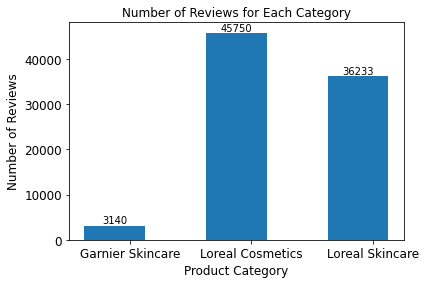

In [ ]:
products_df = english_df.groupby('Product Category').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, len(products_df['Product Category'])+1)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, products_df['count'], width=bar_width, label="Number of Reviews Posted")
ax.set_ylabel("Number of Reviews", fontsize=12)
ax.set_xlabel("Product Category", fontsize=12)
plt.xticks(xtick_pos, products_df['Product Category'],fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Reviews for Each Category")

rects = ax.patches

# Make some labels.
labels = list(products_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 1.3 Number of Reviews Per Product

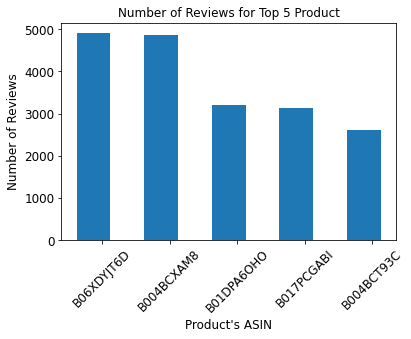

In [ ]:
products_df = english_df.groupby('ASIN').size().reset_index(name='count')
products_df = products_df.sort_values(by=['count'],ascending=False)

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, 6)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, products_df['count'][:5], width=bar_width, label="Number of Reviews")
ax.set_ylabel("Number of Reviews", fontsize=12)
ax.set_xlabel("Product's ASIN", fontsize=12)
plt.xticks(xtick_pos, products_df['ASIN'][:5],rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Reviews for Top 5 Product")

plt.show()

#### 1.4. Median Language Confidence per Category

In [ ]:
category_language_df = english_df.groupby('Product Category').agg({'language_confidence':np.median}).reset_index()
display(category_language_df)

,Product Category,language_confidence
0,Garnier Skincare,99.0
1,Loreal Cosmetics,99.0
2,Loreal Skincare,99.0


#### 1.5 Distribution of Language Confidence

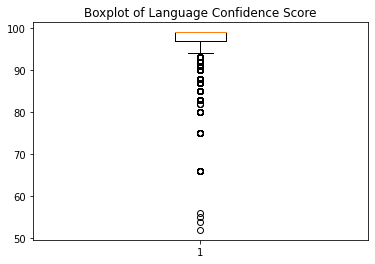

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(english_df['language_confidence']) 
plt.title("Boxplot of Language Confidence Score")
plt.show()

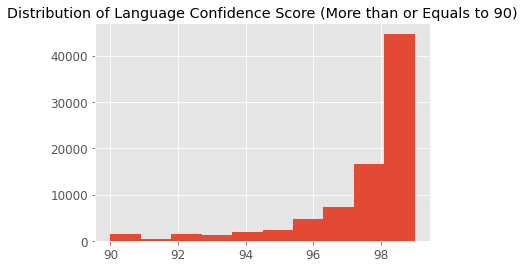

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(english_df[english_df['language_confidence'] >= 90]['language_confidence'], bins=10,label="Number of Reviews")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Language Confidence Score (More than or Equals to 90)")
plt.show()

#### 1.6 Reviews Trend over Years

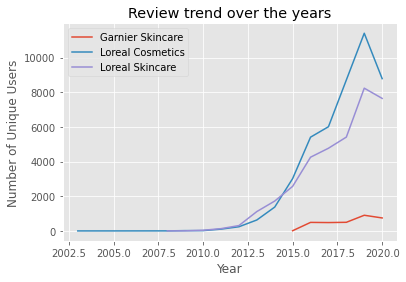

<Figure size 432x288 with 0 Axes>

In [ ]:
english_df['year'] = pd.DatetimeIndex(english_df['date_posted']).year
english_df['month'] = pd.DatetimeIndex(english_df['date_posted']).month

post_df = english_df.groupby(['year','Product Category']).size().reset_index(name='count')

fig, ax = plt.subplots()
fig = plt.figure(facecolor="white")


ax.set_ylabel("Number of Unique Users")
ax.set_xlabel("Year")
ax.set_title("Review trend over the years")

for key, grp in post_df.groupby(['Product Category']):
    ax.plot(grp['year'], grp['count'], label = key)
ax.legend(loc='best')    
plt.show()

#### 1.7 Distribution of Voting

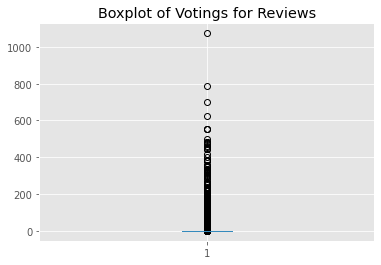

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(english_df['clean_voting']) 
plt.title("Boxplot of Votings for Reviews")
plt.show()

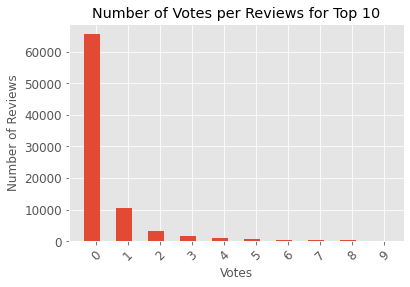

In [ ]:
votings_df = english_df.groupby('clean_voting').size().reset_index(name='count')
votings_df = votings_df.sort_values(by=['count'],ascending=False)

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, 11)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, votings_df['count'][:10], width=bar_width, label="Number of Reviews")
ax.set_ylabel("Number of Reviews", fontsize=12)
ax.set_xlabel("Votes", fontsize=12)
plt.xticks(xtick_pos, votings_df['clean_voting'][:10],rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Votes per Reviews for Top 10")
    
plt.show()

#### 1.8 Distribution of Words in Reviews

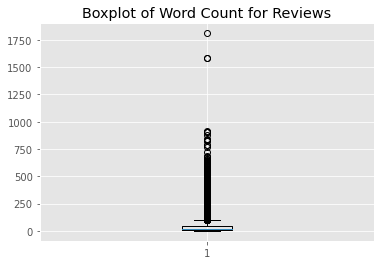

In [ ]:
english_df['word_count'] = english_df['decoded_comment'].str.split().str.len()
english_df['word_count'] = english_df['word_count'].fillna(value=0)

fig = plt.figure(facecolor="white")

plt.boxplot(english_df['word_count']) 
plt.title("Boxplot of Word Count for Reviews")
plt.show()

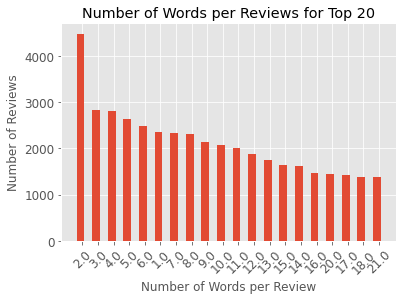

In [ ]:
word_counts_df = english_df.groupby('word_count').size().reset_index(name='count')
word_counts_df = word_counts_df.sort_values(by=['count'],ascending=False)

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, 21)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, word_counts_df['count'][:20], width=bar_width, label="Number of Reviews")
ax.set_ylabel("Number of Reviews", fontsize=12)
ax.set_xlabel("Number of Words per Review", fontsize=12)
plt.xticks(xtick_pos, word_counts_df['word_count'][:20],rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Words per Reviews for Top 20")
plt.show()

### Profiles EDA

#### 2.1. Status of Profiles

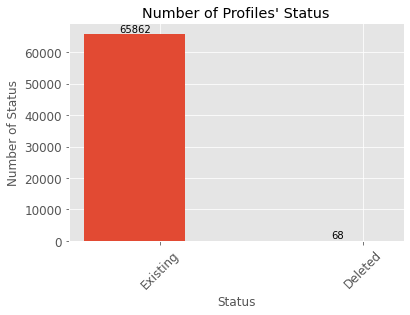

In [ ]:
profile_df['status'] = "Existing"
deleted_df['status'] = "Deleted"
temp_merge_df = pd.concat([profile_df, deleted_df], axis=0)

status_df = temp_merge_df.groupby('status').size().reset_index(name='count')
status_df = status_df.sort_values(by=['count'],ascending=False)

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, 3)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, status_df['count'], width=bar_width, label="Number of Status")
ax.set_ylabel("Number of Status", fontsize=12)
ax.set_xlabel("Status", fontsize=12)
plt.xticks(xtick_pos, status_df['status'],rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Profiles' Status")

rects = ax.patches

# Make some labels.
labels = list(status_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 2.2 Distribution of Ranking

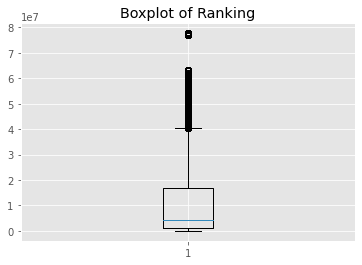

In [ ]:
temp_merge_df['ranking'] = temp_merge_df['ranking'].str.replace(',', '')
temp_merge_df['ranking'] = temp_merge_df['ranking'].fillna(value=0)
temp_merge_df['ranking'] = temp_merge_df['ranking'].astype(int)

fig = plt.figure(facecolor="white")

plt.boxplot(temp_merge_df['ranking']) 
plt.title("Boxplot of Ranking")
plt.show()

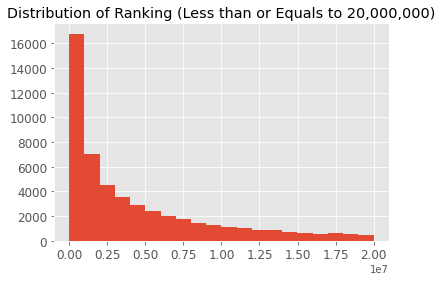

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(temp_merge_df[temp_merge_df['ranking'] <= 20000000]['ranking'], bins=20,label="Number of Profiles")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Ranking (Less than or Equals to 20,000,000)")
plt.show()

#### 2.3 Distribution of marketplaceId

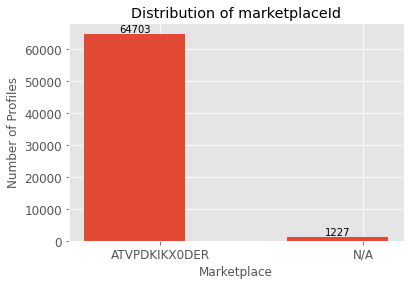

In [ ]:
marketplace_df = pd.merge(temp_merge_df,newest_profile_df[['acc_num','marketplaceId']],left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
marketplace_df = marketplace_df.drop_duplicates(subset='acc_num', keep="first")
marketplace_df['marketplaceId'] = marketplace_df['marketplaceId'].fillna(value="N/A")
marketplace_df = marketplace_df.groupby('marketplaceId').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, len(marketplace_df['marketplaceId'])+1)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, marketplace_df['count'], width=bar_width, label="Number of Profiles")
ax.set_ylabel("Number of Profiles", fontsize=12)
ax.set_xlabel("Marketplace", fontsize=12)
plt.xticks(xtick_pos, marketplace_df['marketplaceId'],fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of marketplaceId")

rects = ax.patches

# Make some labels.
labels = list(marketplace_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 2.4 Distribution of locale

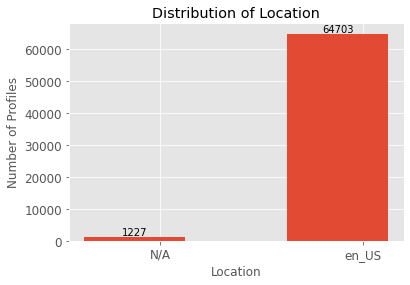

In [ ]:
locale_df = pd.merge(temp_merge_df,newest_profile_df[['acc_num','locale']],left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
locale_df = locale_df.drop_duplicates(subset='acc_num', keep="first")
locale_df['locale'] = locale_df['locale'].fillna(value="N/A")
locale_df = locale_df.groupby('locale').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, len(locale_df['locale'])+1)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, locale_df['count'], width=bar_width, label="Number of Profiles")
ax.set_ylabel("Number of Profiles", fontsize=12)
ax.set_xlabel("Location", fontsize=12)
plt.xticks(xtick_pos, locale_df['locale'],fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Location")

rects = ax.patches

# Make some labels.
labels = list(locale_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 2.5 Distribution of Owner View

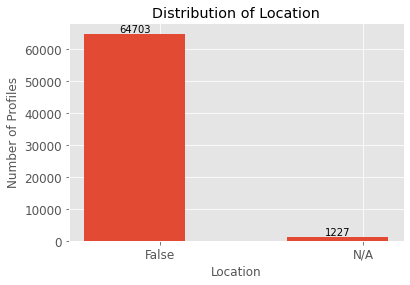

In [ ]:
owner_df = pd.merge(temp_merge_df,newest_profile_df[['acc_num','ownerView']],left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
owner_df = owner_df.drop_duplicates(subset='acc_num', keep="first")
owner_df['ownerView'] = owner_df['ownerView'].fillna(value="N/A")
owner_df = owner_df.groupby('ownerView').size().reset_index(name='count')

fig = plt.figure(facecolor="white")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1, len(owner_df['ownerView'])+1)
tick_pos = [i + bar_width / 2 for i in bar_l]
xtick_pos = [i + bar_width / 4 for i in bar_l]

ax1 = ax.bar(bar_l, owner_df['count'], width=bar_width, label="Number of Profiles")
ax.set_ylabel("Number of Profiles", fontsize=12)
ax.set_xlabel("Location", fontsize=12)
plt.xticks(xtick_pos, owner_df['ownerView'],fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Location")

rects = ax.patches

# Make some labels.
labels = list(owner_df['count'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.show()

#### 2.6 Distribution of Helpful Votes

In [ ]:
average_vote_df = newest_profile_df.groupby('acc_num').agg({'helpfulVotes':np.mean}).reset_index()
average_vote_df = average_vote_df.rename(columns={'helpfulVotes':'average_votes'})
average_vote_df['average_votes'] = average_vote_df['average_votes'].fillna(value=0)

median_vote_df = newest_profile_df.groupby('acc_num').agg({'helpfulVotes':np.median}).reset_index()
median_vote_df = median_vote_df.rename(columns={'helpfulVotes':'median_votes'})
median_vote_df['median_votes'] = median_vote_df['median_votes'].fillna(value=0)

vote_df = pd.merge(average_vote_df,median_vote_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
display(vote_df)

,acc_num,average_votes,median_votes
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,0.10,0.0
1,AE22JJYZQC6KT354WG4JSJCU4WXA,0.00,0.0
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,0.00,0.0
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,1.00,0.0
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,2.75,0.5
...,...,...,...
65858,AHZZONVVQ454QUCD23HMD5E7VNIQ,5.00,0.0
65859,AHZZTMJPOUBTHE3KC3NONEWETDAA,0.10,0.0
65860,AHZZVMDHFFSBOVISWYOV7RX7XBTA,1.40,0.0
65861,comnan,0.00,0.0


##### 2.6.1 Distribution of Average Helpful Votes

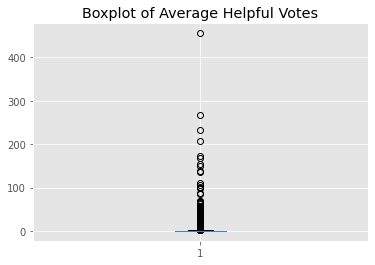

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(vote_df['average_votes']) 
plt.title("Boxplot of Average Helpful Votes")
plt.show()

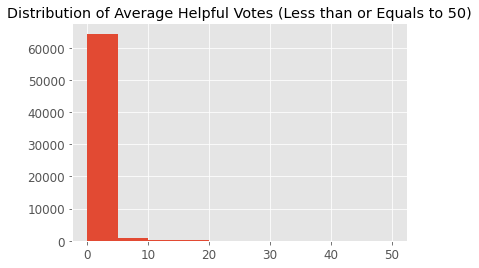

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(vote_df[vote_df['average_votes'] <= 50]['average_votes'], bins=10,label="Number of Votes")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Average Helpful Votes (Less than or Equals to 50)")
plt.show()

##### 2.6.2 Distribution of Median Helpful Votes

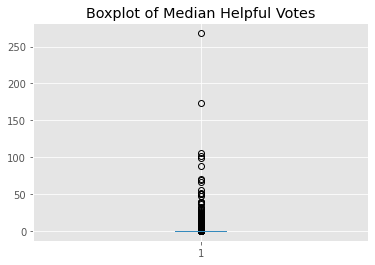

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(vote_df['median_votes']) 
plt.title("Boxplot of Median Helpful Votes")
plt.show()

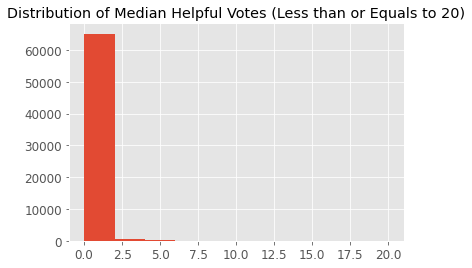

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(vote_df[vote_df['median_votes'] <= 20]['median_votes'], bins=10,label="Number of Votes")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Median Helpful Votes (Less than or Equals to 20)")
plt.show()

#### 2.7 Distribution of Review Count

In [ ]:
average_reviewcount_df = newest_profile_df.groupby('acc_num').agg({'reviewCount':np.mean}).reset_index()
average_reviewcount_df = average_reviewcount_df.rename(columns={'reviewCount':'average_reviewcount'})
average_reviewcount_df['average_reviewcount'] = average_reviewcount_df['average_reviewcount'].fillna(value=0)

median_reviewcount_df = newest_profile_df.groupby('acc_num').agg({'reviewCount':np.median}).reset_index()
median_reviewcount_df = median_reviewcount_df.rename(columns={'reviewCount':'median_reviewcount'})
median_reviewcount_df['median_reviewcount'] = median_reviewcount_df['median_reviewcount'].fillna(value=0)

reviewcount_df = pd.merge(average_reviewcount_df,median_reviewcount_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
display(reviewcount_df)

,acc_num,average_reviewcount,median_reviewcount
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,625.666667,529.0
1,AE22JJYZQC6KT354WG4JSJCU4WXA,0.000000,0.0
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,1196.900000,383.5
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,5239.111111,744.0
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,527.500000,281.0
...,...,...,...
65858,AHZZONVVQ454QUCD23HMD5E7VNIQ,2792.333333,803.0
65859,AHZZTMJPOUBTHE3KC3NONEWETDAA,650.300000,192.0
65860,AHZZVMDHFFSBOVISWYOV7RX7XBTA,13001.800000,5304.5
65861,comnan,0.000000,0.0


##### 2.7.1 Distribution of Average Review Counts

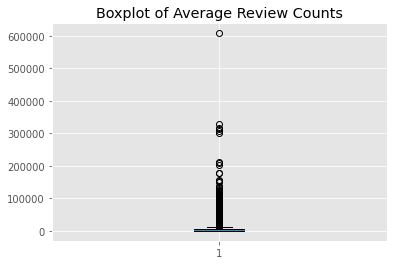

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(reviewcount_df['average_reviewcount']) 
plt.title("Boxplot of Average Review Counts")
plt.show()

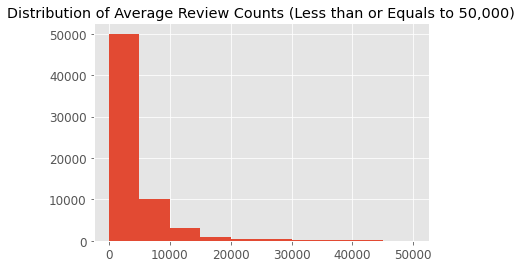

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(reviewcount_df[reviewcount_df['average_reviewcount'] <= 50000]['average_reviewcount'], bins=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Average Review Counts (Less than or Equals to 50,000)")
plt.show()

##### 2.7.2 Distribution of Median Review Counts

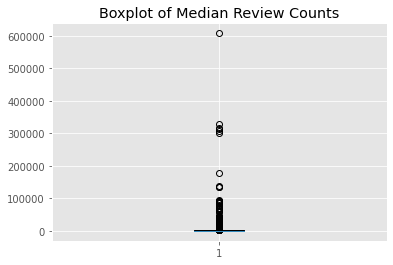

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(reviewcount_df['median_reviewcount']) 
plt.title("Boxplot of Median Review Counts")
plt.show()

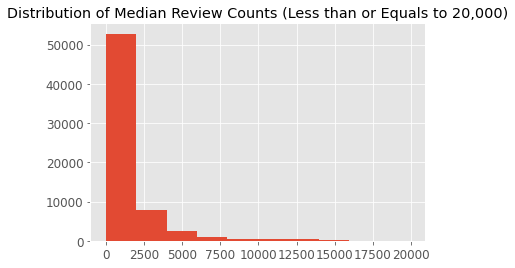

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(reviewcount_df[reviewcount_df['median_reviewcount'] <= 20000]['median_reviewcount'], bins=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Median Review Counts (Less than or Equals to 20,000)")
plt.show()

### 2.8 Distribution of Reviews Posted

In [ ]:
reviewposted_df = newest_profile_df.groupby('acc_num').size().reset_index(name='reviews_posted')
display(reviewposted_df)

,acc_num,reviews_posted
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,10
1,AE22JJYZQC6KT354WG4JSJCU4WXA,1
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,10
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,10
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,8
...,...,...
65858,AHZZONVVQ454QUCD23HMD5E7VNIQ,10
65859,AHZZTMJPOUBTHE3KC3NONEWETDAA,10
65860,AHZZVMDHFFSBOVISWYOV7RX7XBTA,10
65861,comnan,1


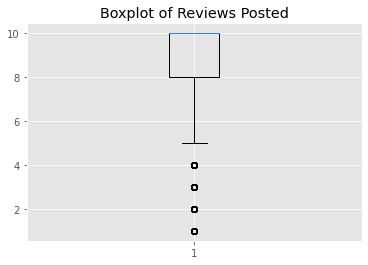

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(reviewposted_df['reviews_posted']) 
plt.title("Boxplot of Reviews Posted")
plt.show()

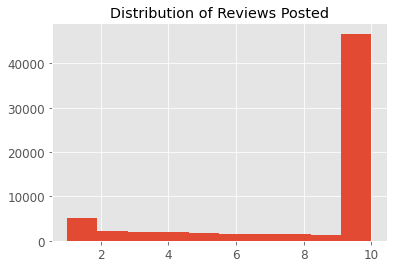

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(reviewposted_df['reviews_posted'], bins=10,label="Number of Reviews")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Reviews Posted")
plt.show()

### 2.9 Distribution of Word Count

In [ ]:
newest_profile_df['word_count'] = newest_profile_df['decoded_comment'].str.split().str.len()
newest_profile_df['word_count'] = newest_profile_df['word_count'].fillna(value=0)

average_wordcount_df = newest_profile_df.groupby('acc_num').agg({'word_count':np.mean}).reset_index()
average_wordcount_df = average_wordcount_df.rename(columns={'word_count':'average_wordcount'})
average_wordcount_df['average_wordcount'] = average_wordcount_df['average_wordcount'].fillna(value=0)

median_wordcount_df = newest_profile_df.groupby('acc_num').agg({'word_count':np.median}).reset_index()
median_wordcount_df = median_wordcount_df.rename(columns={'word_count':'median_wordcount'})
median_wordcount_df['median_wordcount'] = median_wordcount_df['median_wordcount'].fillna(value=0)

profile_wordcount_df = pd.merge(average_wordcount_df,median_wordcount_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
display(profile_wordcount_df)

,acc_num,average_wordcount,median_wordcount
0,AE2242WWRDTRHP3Y4WK2K2GQIOUA,23.100,16.5
1,AE22JJYZQC6KT354WG4JSJCU4WXA,0.000,0.0
2,AE22M5XAIOKNXQT7JSZY3LNU3VOQ,46.500,35.0
3,AE22MKKJATCXH6RL42WXLDUEJ5WQ,25.500,21.0
4,AE22RZJ3SCYG6RZTGJ6HVNFRX7PA,162.625,92.5
...,...,...,...
65858,AHZZONVVQ454QUCD23HMD5E7VNIQ,52.800,52.0
65859,AHZZTMJPOUBTHE3KC3NONEWETDAA,17.700,16.0
65860,AHZZVMDHFFSBOVISWYOV7RX7XBTA,33.000,34.0
65861,comnan,1.000,1.0


#### 2.9.1 Distribution of Average Word Count

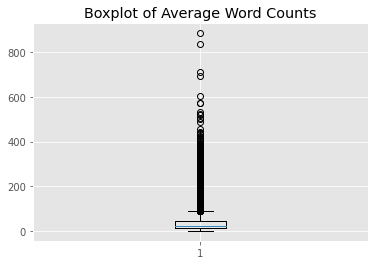

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(profile_wordcount_df['average_wordcount']) 
plt.title("Boxplot of Average Word Counts")
plt.show()

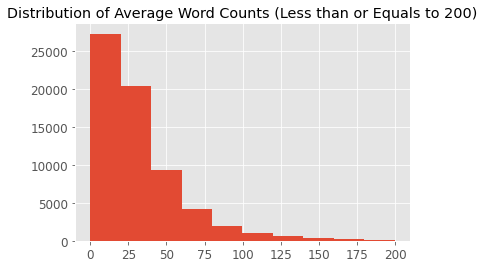

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(profile_wordcount_df[profile_wordcount_df['average_wordcount'] <= 200]['average_wordcount'], bins=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Average Word Counts (Less than or Equals to 200)")
plt.show()

#### 2.9.2 Distribution of Median Word Count

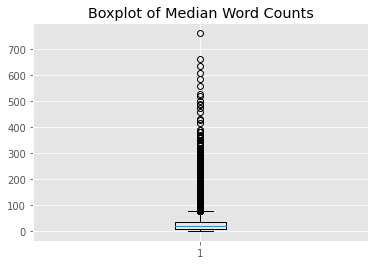

In [ ]:
fig = plt.figure(facecolor="white")

plt.boxplot(profile_wordcount_df['median_wordcount']) 
plt.title("Boxplot of Median Word Counts")
plt.show()

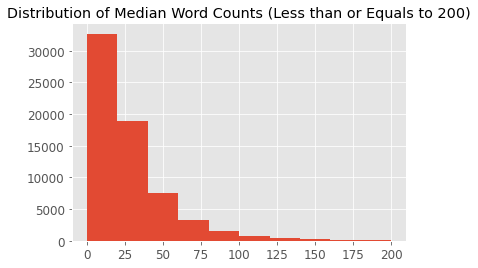

In [ ]:
fig = plt.figure(facecolor="white")

plt.style.use('ggplot')
plt.hist(profile_wordcount_df[profile_wordcount_df['median_wordcount'] <= 200]['median_wordcount'], bins=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Median Word Counts (Less than or Equals to 200)")
plt.show()

### Save Final Dataframe for Use Cases

#### 1. Reviews Dataframe

In [ ]:
%cd '/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/'
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/final_reviews.csv'):
    final_reviews_df = pd.read_csv('final_reviews.csv',encoding='utf-8')
else:
    final_reviews_df = english_df.copy()
    final_reviews_df = final_reviews_df.drop_duplicates()
    final_reviews_df.to_csv('final_reviews.csv',index=False,encoding='utf-8')

display(final_reviews_df)

/content/drive/.shortcut-targets-by-id/1bpW1tlGnHpN_Bnj5vXSvvN4WcvlMjcHm/FYP Y4S1/dataset/final


,ASIN,Product Category,clean_title,decoded_comment,ratings,clean_verified,account_number,clean_voting,location,date_posted,language,language_confidence,clean_product_name,cleaned_text,year,month,word_count
0,B01M09QQI0,Loreal Skincare,love love love,"love, love, love this moisturizer! as a woman ...",1.0,1.0,AHR5T6MM2O3EPWKQS2TBOVXBXLQA,1,United States,"December 11, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,love love love moisturizer woman ha bless many...,2019,12,101.0
1,B01M09QQI0,Loreal Skincare,love it,this moisturizer works so well with my skin. ...,1.0,1.0,AGNSFZ5L2RRLAZVJLP44FFZNOSJA,0,United States,"December 27, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,moisturizer work well skin let start say 37 ye...,2019,12,142.0
2,B01M09QQI0,Loreal Skincare,they say that i look younger!,i know. sounds to good to be true. maybe fol...,1.0,1.0,AEBGB5TXQVZDADM6NVF3PUGZJZQQ,2,United States,"August 13, 2019",English,99.0,face moisturizer l oreal paris skin care age p...,know sound good true maybe folk try nice wa te...,2019,8,78.0
3,B01M09QQI0,Loreal Skincare,old,the first jar i ordered smelled wonderful and ...,0.2,1.0,AGOPMI2JKQH5F2BP2PULHGJVZ74A,6,United States,"October 19, 2018",English,99.0,face moisturizer l oreal paris skin care age p...,first jar order smell wonderful go skin smooth...,2018,10,76.0
4,B01M09QQI0,Loreal Skincare,does what it claims,i have used this product for about six weeks. ...,0.8,1.0,AF7YT2BIHNQZZNOQF6JGKJGGZ2XA,0,United States,"January 10, 2020",English,99.0,face moisturizer l oreal paris skin care age p...,use product six week 62 daily moisturizer ha m...,2020,1,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,B0047ENUXE,Loreal Cosmetics,NaN,everlasting plum is my favorite shade. very pi...,0.8,1.0,NaN,0,NaN,"July 23, 2018",English,99.0,paris infallible le rouge lipstick always apri...,everlasting plum favorite shade pigmented matt...,2018,7,37.0
85093,B0047ENUXE,Loreal Cosmetics,NaN,i got this for 564 i mean this is a steal for ...,1.0,1.0,NaN,1,NaN,"October 11, 2017",English,99.0,paris infallible le rouge lipstick always apri...,get 564 mean steal price rambling rise beautif...,2017,10,40.0
85094,B0047ENUXE,Loreal Cosmetics,NaN,i love the color absolutely. it brightens up t...,0.8,1.0,NaN,0,NaN,"July 12, 2015",English,99.0,paris infallible le rouge lipstick always apri...,love color absolutely brighten face immediatel...,2015,7,151.0
85095,B0047ENUXE,Loreal Cosmetics,NaN,very nice shade to give you pink lips..quality...,1.0,1.0,NaN,0,NaN,"December 11, 2018",English,99.0,paris infallible le rouge lipstick always apri...,nice shade give pink lipstick shine moisture g...,2018,12,28.0


#### 2. Profiles Dataframe

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/final_profiles.csv'):
    final_profiles_df = pd.read_csv('final_profiles.csv',encoding='utf-8')
else:
    final_profiles_df = temp_merge_df.copy()

    final_profiles_df = pd.merge(final_profiles_df,vote_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df = pd.merge(final_profiles_df,reviewcount_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df = pd.merge(final_profiles_df,profile_wordcount_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    final_profiles_df = pd.merge(final_profiles_df,reviewposted_df,left_on=['acc_num'], right_on = ['acc_num'], how = 'left')
    
    
    final_profiles_df.to_csv('final_profiles.csv',index=False,encoding='utf-8')

display(final_profiles_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,status,average_votes,median_votes,average_reviewcount,median_reviewcount,average_wordcount,median_wordcount,reviews_posted
0,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,Existing,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,Existing,0.0,0.0,5343.0,5343.0,17.0,17.0,1.0
2,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,Existing,0.4,0.0,1729.5,352.0,107.6,105.0,10.0
3,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHDJNPXWQMD5N2CHG7Q6KQDJPRRA,JD Hart,NaN,NaN,NaN,NaN,36302371,Existing,0.8,0.0,1572.4,487.0,33.1,17.0,10.0
4,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AENWE3IEOTCHQNSTWT37HQAAOV3A,Tine bop,Flight attendant,Nevada,Traveler. fitness enthusiast. animal lover,NaN,209129,Existing,0.0,0.0,285.0,295.5,42.0,39.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65925,NaN,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0
65926,NaN,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0
65927,NaN,AHMOP3NAJYENMX2QZY2KJXZOM6PQ,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0
65928,NaN,AENTI3ZAMQODCBRZODESI24UTPFA,NaN,NaN,NaN,NaN,NaN,0,Deleted,0.0,0.0,0.0,0.0,1.0,1.0,1.0


#### 3. Reviews Posted by Profiles *Dataframe*

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/final_reviews_posted_by_profiles.csv'):
    final_reviews_posted_by_profiles_df = pd.read_csv('final_reviews_posted_by_profiles.csv',encoding='utf-8')
else:
    final_reviews_posted_by_profiles_df = newest_profile_df.copy()

    final_reviews_posted_by_profiles_df.to_csv('final_reviews_posted_by_profiles.csv',index=False,encoding='utf-8')

display(final_reviews_posted_by_profiles_df)

,acc_num,name,occupation,location,description,badges,ranking,marketplaceId,locale,ownerView,id,externalId,sortTimestamp,rating,visibility,helpfulVotes,title,text,writtenInLanguageCode,images,verifiedPurchase,vine,zebra,type,attachments,asin,product,link,image,reviewCount,averageRating,fullStarCount,hasHalfStar,missing,prime,attachmentType,status,decoded_comment,clean_product_name,cleaned_text,word_count
0,AG3SZWYYCVNKZFTF5ONOHIR2W3ZQ,Melissa,NaN,NaN,NaN,NaN,9414533,ATVPDKIKX0DER,en_US,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Existing,NaN,NaN,NaN,0.0
1,AE2GLRIB53WWNGS3LFPDBK4FHOXA,Molly c. Haviland,NaN,NaN,NaN,NaN,63277988,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2CTFW6C5WM2O8,R2CTFW6C5WM2O8,1.522119e+12,5.0,public,0.0,Five Stars,Works great! No smudge and comes off easy. It...,en_US,[],True,False,False,productreview,"[{'asin': 'B001IAINFU', 'title': ""L'Oreal Pari...",B001IAINFU,L'Oreal Paris Makeup Double Extend Beauty Tube...,/LOr%C3%A9al-Paris-Makeup-Lengthening-Mascara/...,https://m.media-amazon.com/images/I/31NZIGw5cp...,5343.0,4.5,4.0,True,False,False,PRODUCT,Existing,works great! no smudge and comes off easy. it...,loreal paris makeup double extend beauty tube ...,work great smudge come easy make lashed long d...,17.0
2,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R2C05U4X4HY5B1,R2C05U4X4HY5B1,1.500857e+12,5.0,public,0.0,Five Stars,I am elderly with very thin and fragil skin an...,en_US,[],True,False,False,productreview,"[{'asin': 'B01DBKRWWY', 'title': 'Quilted Nort...",B01DBKRWWY,"Quilted Northern Ultra Plush Toilet Paper, 12 ...",/Quilted-Northern-Toilet-Double-Regular/dp/B01...,https://m.media-amazon.com/images/I/61jh4+xGlo...,4661.0,4.6,4.0,True,False,False,PRODUCT,Existing,i am elderly with very thin and fragil skin an...,quilted northern ultra plush toilet paper 12 d...,elderly thin fragil skin preferred choice,15.0
3,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.RP51NSSEMHKJK,RP51NSSEMHKJK,1.500857e+12,5.0,public,0.0,A Joy to Read,This book was so enjoyable for me. After suff...,en_US,[],True,False,False,productreview,"[{'asin': 'B00DP64BN8', 'title': 'Nora Roberts...",B00DP64BN8,"Nora Roberts Land (Dare Valley Series, Book 1)",/Nora-Roberts-Land-Dare-Valley-ebook/dp/B00DP6...,https://m.media-amazon.com/images/I/510SzAAOqo...,5969.0,4.3,4.0,True,False,False,PRODUCT,Existing,this book was so enjoyable for me. after suff...,nora robert land dare valley series book 1,book wa enjoyable suffer severe concussion wa ...,159.0
4,AF74PPSRBCD46LSS3AIOH3CZ6UYA,Kate 9373,Retired,"Lafayette, LA.",I am 82 years old and semi-retired. I love to ...,NaN,8303158,ATVPDKIKX0DER,en_US,False,amzn1.productreview.R14B9T2VHFGWH9,R14B9T2VHFGWH9,1.500855e+12,1.0,public,0.0,Do not purchase this model,This opener will not operate on the types of c...,en_US,[],True,False,False,productreview,"[{'asin': 'B06WVBTT2D', 'title': 'Electric Can...",B06WVBTT2D,"Electric Can Opener, Sokos Smooth Soft Edge El...",/Electric-Opener-Smooth-One-Button-Manual/dp/B...,https://m.media-amazon.com/images/I/51dD+PfxnY...,57.0,2.1,2.0,False,False,False,PRODUCT,Existing,this opener will not operate on the types of c...,electric opener sokos smooth soft edge electri...,opener operate type purchase caution wa purcha...,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544558,AE7QXN445XC7O5SJHCU3WVVZLQ7Q,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deleted,none,NaN,none,1.0
544559,AEDVTPZKQWXB56QZT3WWBNQJBD7Q,NaN,NaN,NaN,NaN,NaN,0,

#### 4. Product Information

In [ ]:
if os.path.exists('/content/drive/My Drive/FYP/FYP Y4S1/dataset/final/final_products.csv'):
    final_products_df = pd.read_csv('final_products.csv',encoding='utf-8')
else:
    final_products_df = product_info_df.copy()

    final_products_df.to_csv('final_products.csv',index=False,encoding='utf-8')

display(final_products_df)

,asin,description,price,rating,availability,decoded_comment,clean_rating,clean_price,cleaned_text
0,B0000531SW,NaN,NaN,NaN,NaN,,0.00,0.00,
1,B00005333G,L’Oreal Paris Hydra-Renewal is a day and night...,NaN,4.3 out of 5,NaN,loreal paris hydra-renewal is a day and night ...,0.86,0.00,loreal paris day night facial moisturizer help...
2,B00005333I,L'OREAL PARIS DERMO-EXPERTISE EYE CREAM: this ...,NaN,4.3 out of 5,NaN,l'oreal paris dermo-expertise eye cream: this ...,0.86,0.00,loreal paris eye cream light gel eye cream cir...
3,B000KOLX7U,NaN,NaN,NaN,NaN,,0.00,0.00,
4,B000KOLXKM,NaN,NaN,NaN,NaN,,0.00,0.00,
...,...,...,...,...,...,...,...,...,...
102,B07TVMFM5C,NaN,NaN,NaN,NaN,,0.00,0.00,
103,B07X82S53H,Lightweight Breathable Longwear: This foundati...,NaN,4.5 out of 5,NaN,lightweight breathable longwear: this foundati...,0.90,0.00,lightweight breathable longwear foundation pro...
104,B07YGB5SPC,NaN,NaN,NaN,NaN,,0.00,0.00,
105,B07Z9WFWZ8,RADIANT SERUM FOUNDATION: This carefully formu...,NaN,4.3 out of 5,NaN,radiant serum foundation: this carefully formu...,0.86,0.00,radiant serum foundation carefully formulate f...
